In [131]:
from sklearn import metrics
# from sklearn import model_selection
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression

from collections import defaultdict
from collections import Counter

from time import time

import pandas as pd
import numpy as np

import src.utilities as ut

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Import data set:

In [132]:
pd.options.mode.chained_assignment = None


df_full = ut.import_dataset(encoding='utf-8')
df_full.head()

,text,class
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",Ανθρωποκτονία
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",Ανθρωποκτονία
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",Ανθρωποκτονία
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",Ανθρωποκτονία
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",Ανθρωποκτονία


Kept only the column of interest leaving out the column with `class` labels.

In [133]:
df = df_full[['text']]
df['text'] = df['text'].astype('string')

df.head()

,text
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


# Exploratory Data Analysis:

Let's do a little bit of EDA of these texts.

## Length of texts:

In [134]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,517.0,2584.237911,2233.321715,144.0,1336.0,1902.0,3066.0,20566.0


Visualize the results above using a boxplot:

<AxesSubplot:>

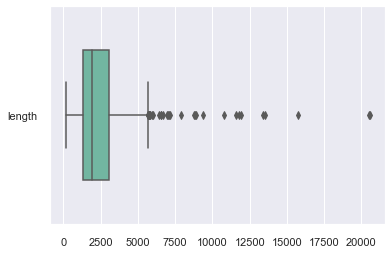

In [135]:
# Box plot:
sns.set_theme(style="darkgrid")
sns.boxplot(data=df, orient='h', width=.6, palette="Set2")

When the median is closer to the bottom of the box and the whisker is shorter on the lower end of the box, the distribution is right-skewed (or “positively” skewed). This probably means that the classifier we are trying to built here will be better at predicting the class of the given text, for texts that are of relatively small length.

We can try to apply some kind of transformation in order to deal with skewness. This step eould crucial if the length of texts could play an important role in classifying them.

Below a `log transformation` is use in order to create a more *gaussian-like* distribution.

In [136]:
df['log_length'] = np.log(df['length'])

After this we create a new boxplot in order to visualize the data once again.

<AxesSubplot:>

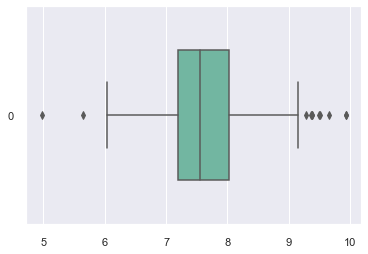

In [137]:
sns.boxplot(data=df['log_length'], orient='h', width=.6, palette="Set2")

# Text processing:

Now we will create a **pipeline** in order to process the textual data we have. The **pipeline** will consist of the following steps:

- Lowercase all characters
- Drop numbers
- Remove punctuation
- Remove stopwords. The list of stopwords can be found here.
- Remove intonation from words.
- Tokenization
- Lemmatization. The process during which all words are turned into their roots.
- Finally, single letter words are dropped, too.

Of course, the above **pipeline** can be adjusted by moving or adding other steps depending on the use case.

In [138]:
pipeline = [str.lower, ut.drop_numbers, ut.remove_punctuation, ut.remove_stopwords, ut.remove_intonation, 
    ut.tokenize_regex, ut.lemmatize, ut.drop_single_letter_words, ut.remove_final_s]

Apply the process pipeline:

In [139]:
df['tokens'] = df['text'].apply(ut.process, pipeline=pipeline)

Add column to see the number of tokens:

In [140]:
df['num_tokens'] = df['tokens'].map(len)

See `datatypes` of resulting columns:
We want to make sure we are dealing with `strings`.

In [141]:
datatypes = df.dtypes
print(datatypes)

text           string
length          Int64
log_length    Float64
tokens         object
num_tokens      int64
dtype: object


Turn **tokens** column from pandas `object` to `string` and see data types again:

In [142]:
df['tokens'] = df['tokens'].astype('string')

datatypes = df.dtypes
print(datatypes)

text           string
length          Int64
log_length    Float64
tokens         string
num_tokens      int64
dtype: object


The last thing in order to be able to proceed to classification analysis. We need to add the **labels** column back. Therefore, we set up the dataset with both the processed text & their respective classes.

In [143]:
df['label'] = df_full['class']
df.columns = ['text', 'length', 'log_length','tokens', 'num_tokens', 'label']

Check out the resulting `DataFrame`.

In [144]:
df.head()

,text,length,log_length,tokens,num_tokens,label
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",1627,7.394493,ξεκινησε πρωι ενωπιον δικαστων μικτου ορκωτο ε...,1190,Ανθρωποκτονία
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",3464,8.150179,αλλο ακρο εχω περαω πλεον διαδηλωσει σε ο ΗΠΑ ...,2589,Ανθρωποκτονία
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",2914,7.977282,λεει κουβεντα γερμανο καταδικασμενο παιδοφιλο ...,2140,Ανθρωποκτονία
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",2702,7.901748,χρονο απο θανατο ειρηνη λαγουδη μητερα τριο πα...,2086,Ανθρωποκτονία
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",2371,7.771067,ένα εβδομαδα αρχικο εκτιμηση οτι μαντλιν μακκα...,1808,Ανθρωποκτονία


# Classification analysis:

Text(0, 0.5, 'labels')

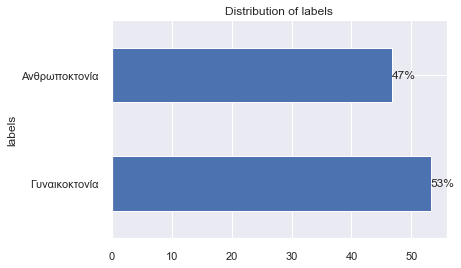

In [145]:
# Plot with normalized values:
ax = df['label'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', title='Distribution of labels')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
# ax.set_xlabel('% of labels')
ax.set_ylabel('labels')

In [146]:
# Create Feature (tokens) and Label (label) sets:
X = df['tokens']
y = df['label']

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

Training Data Shape: (346,)
Testing Data Shape:  (171,)


Vectorize data:

In [148]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_train_tfidf.shape

(346, 15158)

Create a pipeline and train the models

In [149]:
# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

See results for the `Naïve Bayes` classifier:

Make predictions and see the confusion matrix:

In [152]:
text_clf_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [153]:
# Form a prediction set
predictions = text_clf_nb.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))


[[50 25]
 [ 2 94]]


Classification report:

In [154]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

               precision    recall  f1-score   support

Ανθρωποκτονία       0.96      0.67      0.79        75
Γυναικοκτονία       0.79      0.98      0.87        96

     accuracy                           0.84       171
    macro avg       0.88      0.82      0.83       171
 weighted avg       0.87      0.84      0.84       171



Overall accuracy of `Naïve Bayes` classifier:

In [155]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.8421052631578947


See the results for the `LinearSVC` classifier:

In [156]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [157]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

print(metrics.confusion_matrix(y_test,predictions))


[[68  7]
 [ 9 87]]


Classification report:

In [158]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

               precision    recall  f1-score   support

Ανθρωποκτονία       0.88      0.91      0.89        75
Γυναικοκτονία       0.93      0.91      0.92        96

     accuracy                           0.91       171
    macro avg       0.90      0.91      0.91       171
 weighted avg       0.91      0.91      0.91       171



Overall accuracy of `LinearSVC` classifier:

In [159]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.9064327485380117
